In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

In [41]:
filenames = sorted(glob.glob('Ball/*.png'))

In [43]:
for filename in filenames:
    img = plt.imread(filename)
    img = cv2.flip(img, 0)
    img = cv2.flip(img, 1)

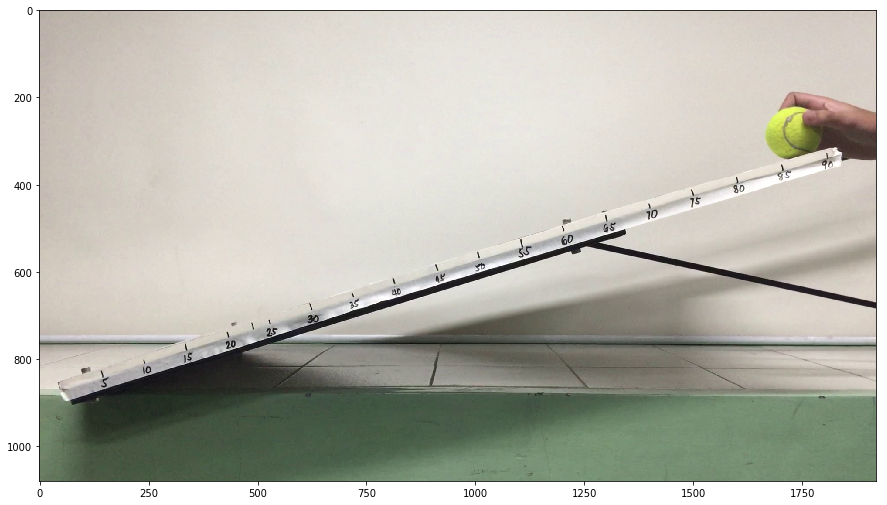

In [33]:
img = plt.imread('Inclined_plane/frame0.png')
img = cv2.flip(img, 0)
img = cv2.flip(img, 1)
#img = plt.imread('tennis.png')
#img = img[10:]
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

In [31]:
ROI1 = plt.imread('roi1.png')
ROI2 = plt.imread('roi2.png')

In [17]:
#for blurry ball
#ROI2 = plt.imread('ROI2.jpg')
#plt.imshow(ROI2)

In [18]:
def RGB(array):
    return array[:,:,0], array[:,:,1], array[:,:,2]

In [19]:
#First Region of Interest

R_img,G_img,B_img = RGB(img)
R_img_crop,G_img_crop,B_img_crop = RGB(ROI1)

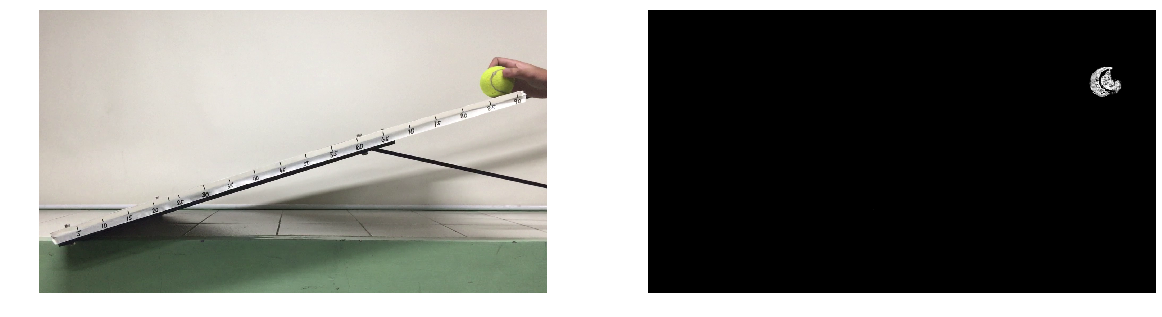

In [20]:
def NCC(R,G,B):
    I = R + G + B
   
    I[I == 0] = 1000000
    
    r = R / I
    g = G / I
    b = 1 - r - g

    return r, g ,b 

r_img,g_img,b_img = NCC(R_img,G_img,B_img)

r_img_crop,g_img_crop,b_img_crop = NCC(R_img_crop,G_img_crop,B_img_crop)

b_img = 1 - r_img.flatten() - g_img.flatten()
b_img[b_img < 0] = 0
b_img_crop = 1 - r_img_crop.flatten() - g_img_crop.flatten()
b_img_crop[b_img_crop < 0] = 0


colors_img = list(zip(r_img.flatten(), g_img.flatten(),b_img))
colors_crop = list(zip(r_img_crop.flatten(), g_img_crop.flatten(), b_img_crop))

def PDF(x_img, x_crop):
    mu = np.mean(x_crop)
    sigma = np.std(x_crop)
    
    factor1 = (1 / (sigma * np.sqrt(2*np.pi)))
    factor2 = np.exp(-(x_img - mu)**2 / (2*(sigma**2)))
    
    return factor1*factor2

p_r = PDF(r_img, r_img_crop)
p_g = PDF(g_img, g_img_crop)

join_p = p_r * p_g

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)

plt.imshow(join_p, cmap='gray')
plt.axis('off')
plt.show()

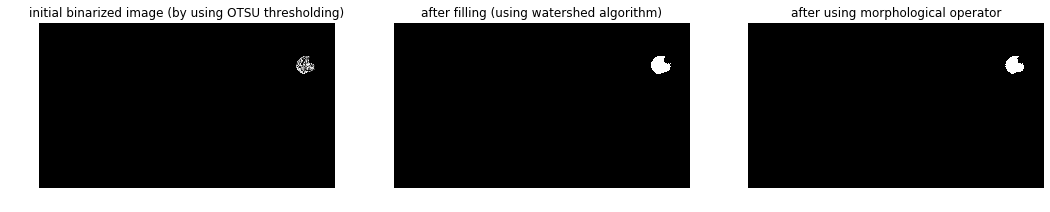

In [21]:
#img = cv2.imread('cell_final.png')
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

thresh = join_p.copy()
thresh = thresh.astype(np.uint8)
plt.figure(figsize=[18,6])

plt.subplot(131)
plt.imshow(thresh, cmap = 'gray')
plt.axis('off')
plt.title('initial binarized image (by using OTSU thresholding)')

im_th = thresh.copy()
im_floodfill = im_th.copy()

# Mask used to flood filling.
# NOTE: the size needs to be 2 pixels bigger on each side than the input image
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255)

# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

# Combine the two images to get the foreground
im_out = im_th | im_floodfill_inv

plt.subplot(132)
plt.imshow(im_out, cmap = 'gray')
plt.axis('off')
plt.title('after filling (using watershed algorithm)')


thresh = im_out.copy()
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
thresh = cv2.erode(thresh, ellipse, iterations = 1)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, ellipse, iterations = 1)


plt.subplot(133)
plt.imshow(thresh, cmap = 'gray')
plt.axis('off')
plt.title('after using morphological operator')
plt.show()

In [22]:
import argparse
import imutils
import cv2

In [23]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [24]:
cX = []
cY = []
area = []
for c in cnts:
    M = cv2.moments(c)
    if M['m00'] != 0.0:
        area.append(cv2.contourArea(c))
        cX.append(int(M["m10"] / M["m00"]))
        cY.append(int(M["m01"] / M["m00"]))

In [25]:
from skimage import measure

In [26]:
cY

[274]

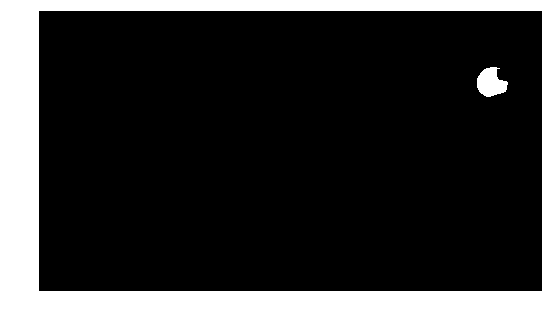

In [29]:
plt.figure(figsize=[9,6])
plt.imshow(thresh, cmap = 'gray')
#plt.scatter(cX, cY)
plt.axis('off')
#plt.title('after using morphological operator')
plt.show()

In [189]:
# loop frames find the centroid per frame